A lot of the code is from here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
%cd drive/MyDrive/colab_projects/cocoapi/PythonAPI/

[Errno 2] No such file or directory: 'drive/MyDrive/colab_projects/cocoapi/PythonAPI/'
/content/drive/My Drive/colab_projects/cocoapi/PythonAPI


In [76]:
%ls

1-data-prep.ipynb
2.5_copy_train1_and_dev1_images_into_separate_folders_for_colab.ipynb
2-splits.ipynb
3-pytorch-dataloader.ipynb
4-fine-tuning-resnet18.ipynb
disjoint-categories.ipynb
Makefile
pycocoDemo.ipynb
pycocoEvalDemo.ipynb
pycocotools/
setup.py
utils/


# Imports

In [77]:
import os
import copy

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision.io import read_image
from torchvision import datasets, models, transforms

from tqdm.notebook import trange, tqdm

In [78]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [79]:
%cd ./utils/
from dataloaders import CocoNoCropping
from config import CATEGORIES_OF_INTEREST; print(CATEGORIES_OF_INTEREST)
# help(CocoNoCropping) # should not be blank
%cd ..

/content/drive/My Drive/colab_projects/cocoapi/PythonAPI/utils
['bird', 'cat', 'dog', 'person']
/content/drive/My Drive/colab_projects/cocoapi/PythonAPI


# Transforms, Datasets, and Data Loaders

In [80]:
# # Data augmentation and normalization for training
# # Just normalization for validation
# data_transforms = {
#     'train1': transforms.Compose([
#         transforms.Resize(size=(224, 224)),
#         transforms.RandomHorizontalFlip(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'dev': transforms.Compose([
#         transforms.Resize(size=(224, 224)),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# data_dir = 'data/hymenoptera_data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

In [81]:
train_transforms = torch.nn.Sequential(
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(), # simple augmentation
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet constants
)

dev_transforms = torch.nn.Sequential(
    transforms.Resize(size=(224, 224)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet constants
)

In [82]:
train1_dataset = CocoNoCropping(
    img_ids = '../my_splits/train1_ids.txt',
    my_annotations_file = '../my_annotations/imgIds_to_labels_train2017.json',
    img_dir = '../my_images/train1/',
    transform=train_transforms,
    divide_by_255=True
)

dev1_dataset = CocoNoCropping(
    img_ids = '../my_splits/dev1_ids.txt',
    my_annotations_file = '../my_annotations/imgIds_to_labels_train2017.json',
    img_dir = '../my_images/dev1/',
    transform=dev_transforms,
    divide_by_255=True
)

In [83]:
# droplast since the number of images is likely not to be divisible by batch_size
train1_dataloader = DataLoader(train1_dataset, batch_size=32, shuffle=True, drop_last=True)
dev1_dataloader = DataLoader(dev1_dataset, batch_size=32, shuffle=False, drop_last=True)

# Visualize a few images

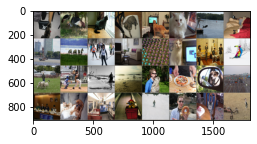

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
bird,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
cat,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
dog,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
person,0,0,0,0,0,0,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,1,0,0,1,0,0,0,1,1,0,0


In [84]:
fig, ax = plt.subplots(figsize=(18, 2))
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    
    # ImageNet constants
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
batch = next(iter(train1_dataloader))
inputs, labels = batch['image'], batch['label']

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

pd.DataFrame({CATEGORIES_OF_INTEREST[i]: labels[i].numpy() for i in range(len(labels))}).T

# Training and Validation Loops

In [85]:
def train_one_epoch(iterator, model, criterion, optimizer):
    total = 0
    epoch_loss = 0
    per_class_correct = torch.zeros(4)
    
    for batch in tqdm(iterator, desc='train'):
        model.train()

        inputs = batch['image'].to(device) # [batch size, channel, h, w]
        #print(inputs.shape, inputs.dtype)
        # right now, `labels` is a list with num_classes tensors, each tensor with batch_size of labels (integers)
        labels = torch.vstack(batch['label']).T.contiguous().to(torch.float32).to(device)
        #print(labels.shape, labels.dtype, labels.is_contiguous()) # labels
        total += labels.shape[0]
        
        optimizer.zero_grad()

        outputs = model(inputs) #logits
        #print(outputs.shape, outputs.dtype, outputs.is_contiguous())
        #print(outputs)

        loss = criterion(outputs, labels)
        epoch_loss += loss.item() # no need to drag 
        #print(loss.item())

        loss.backward()
        optimizer_ft.step()

        preds = (outputs > 0.5).detach().to(torch.int32) # no need to drag the gradients
        #print(preds)
        per_class_correct += (preds.cpu() == labels.cpu()).sum(0) # 0-th axis for batch_size
        #print(per_class_correct)
    
    avg_epoch_loss = epoch_loss / total
    avg_per_class_acc = per_class_correct / total
    
    return avg_epoch_loss, avg_per_class_acc

In [86]:
def evaluate(iterator, model, criterion):
    total = 0
    epoch_loss = 0
    per_class_correct = torch.zeros(4)
    
    for batch in tqdm(iterator, desc='dev'):
        
        # no need for gradients, batch-norm and dropout in evaluation mode
        model.eval()
        with torch.no_grad():
            
            inputs = batch['image'].to(device) # [batch size, channel, h, w]
            #print(inputs.shape, inputs.dtype)
            # right now, `labels` is a list with num_classes tensors, each tensor with batch_size of labels (integers)
            labels = torch.vstack(batch['label']).T.contiguous().to(torch.float32).to(device)
            #print(labels.shape, labels.dtype, labels.is_contiguous()) # labels
            total += labels.shape[0]

            outputs = model(inputs) #logits
            #print(outputs.shape, outputs.dtype, outputs.is_contiguous())
            #print(outputs)

            loss = criterion(outputs, labels)
            epoch_loss += loss.item() # no need to drag 
            #print(loss.item())

            preds = (outputs > 0.5).detach().to(torch.int32) # no need to drag the gradients
            #print(preds)
            per_class_correct += (preds.cpu() == labels.cpu()).sum(0) # 0-th axis for batch_size
            #print(per_class_correct)
    
    avg_epoch_loss = epoch_loss / total
    avg_per_class_acc = per_class_correct / total
    
    return avg_epoch_loss, avg_per_class_acc

# Fine-tune only the last layer

In [87]:
device

'cuda:0'

In [88]:
# load pre-trained model
model_ft = models.resnet18(pretrained=True)

# freese all parameters initially
for param in model_ft.parameters():
    param.requires_grad = False
    
# unfreeeze model parameters of the last layer
for param in model_ft.fc.parameters():
    param.requires_grad = True

# replace the last layer to fit the task
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, len(CATEGORIES_OF_INTEREST))

# place it on the device
model_ft = model_ft.to(device)

criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

In [89]:
#model_ft


Train Avg Acc: 0.7992187738418579
Train Loss: 2.25324627161026
Train Accs per class: tensor([0.7922, 0.8500, 0.7906, 0.7641])




Dev Avg Acc: 0.7964843511581421
Dev Loss: 2.5903433471918107
Dev Accs per class: tensor([0.7937, 0.7703, 0.8453, 0.7766])


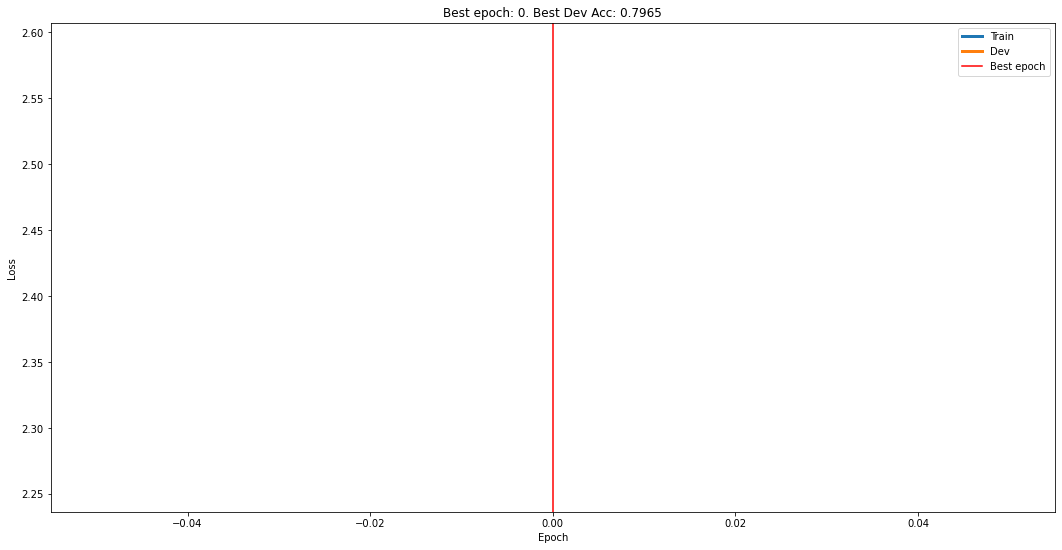


--------------------------------------------------------------------------------




Train Avg Acc: 0.835156261920929
Train Loss: 1.9332696914672851
Train Accs per class: tensor([0.8656, 0.8328, 0.8500, 0.7922])




Dev Avg Acc: 0.8355469107627869
Dev Loss: 2.3369307965040207
Dev Accs per class: tensor([0.8078, 0.8828, 0.8109, 0.8406])


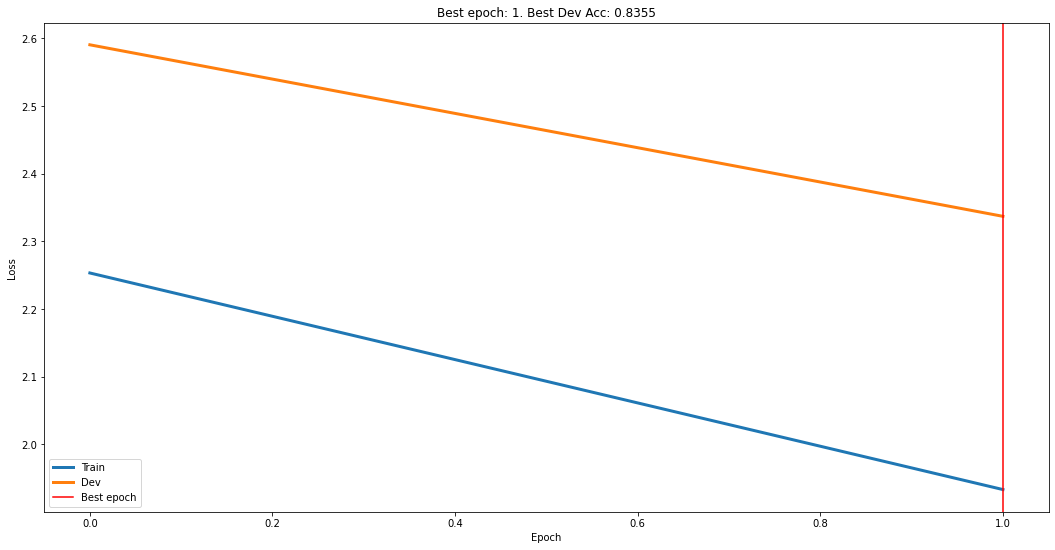


--------------------------------------------------------------------------------




Train Avg Acc: 0.889843761920929
Train Loss: 1.1287259966135026
Train Accs per class: tensor([0.8859, 0.9156, 0.8750, 0.8828])




Dev Avg Acc: 0.8523437976837158
Dev Loss: 1.7893472969532014
Dev Accs per class: tensor([0.8469, 0.8891, 0.8328, 0.8406])


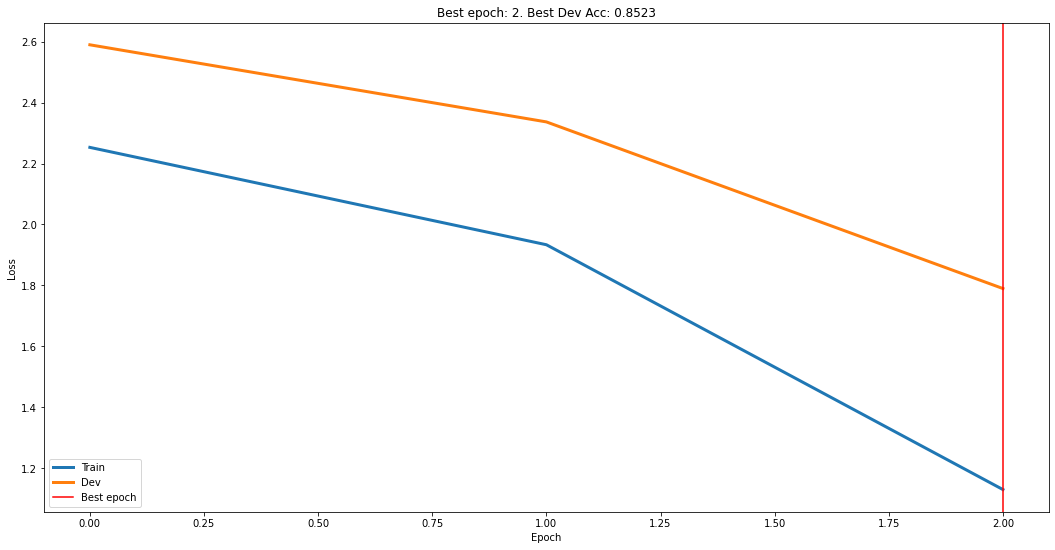


--------------------------------------------------------------------------------




Train Avg Acc: 0.9046875238418579
Train Loss: 0.992684680223465
Train Accs per class: tensor([0.9016, 0.9234, 0.8953, 0.8984])




Dev Avg Acc: 0.850390613079071
Dev Loss: 1.774703386425972
Dev Accs per class: tensor([0.8453, 0.8813, 0.8391, 0.8359])


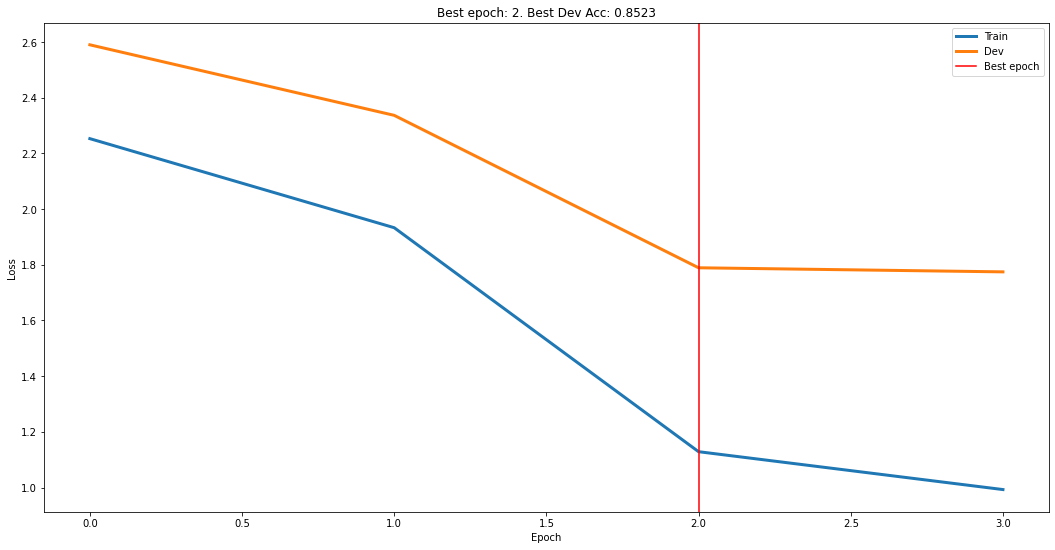


--------------------------------------------------------------------------------


CPU times: user 49.4 s, sys: 2.22 s, total: 51.6 s
Wall time: 56.2 s


In [90]:
%%time

num_epochs = 4
train_epoch_loss_history = []
train_per_class_acc_history = []

dev_epoch_loss_history = []
dev_per_class_acc_history = []

dev_epoch_acc_history = []
train_epoch_acc_history = []

best_acc = None
best_epoch = None

best_model_wts = copy.deepcopy(model_ft.state_dict())

for epoch in trange(num_epochs, desc='epoch'):
    # train
    avg_epoch_loss, avg_per_class_acc = train_one_epoch(iterator=train1_dataloader,
                                                        model=model_ft, criterion=criterion,
                                                        optimizer=optimizer_ft)
    avg_acc = avg_per_class_acc.mean().item()
    train_epoch_acc_history.append(avg_acc)
    print('Train Avg Acc:', avg_acc)
    train_epoch_loss_history.append(avg_epoch_loss)
    train_per_class_acc_history.append(avg_per_class_acc)
    print('Train Loss:', avg_epoch_loss)
    print('Train Accs per class:', avg_per_class_acc)
    print()
    
    # evaluate on the dev set
    avg_epoch_loss, avg_per_class_acc = evaluate(iterator=dev1_dataloader,
                                                 model=model_ft, criterion=criterion)
    avg_acc = avg_per_class_acc.mean().item()
    dev_epoch_acc_history.append(avg_acc)
    print('Dev Avg Acc:', avg_acc)
    dev_epoch_loss_history.append(avg_epoch_loss)
    dev_per_class_acc_history.append(avg_per_class_acc)
    print('Dev Loss:', avg_epoch_loss)
    print('Dev Accs per class:', avg_per_class_acc)
    
    
        
    if (not best_acc) or avg_acc > best_acc:
        best_epoch = epoch
        best_acc = avg_acc
        
        best_model_wts = copy.deepcopy(model_ft.state_dict())

    # lr scheduler step
    exp_lr_scheduler.step()

    # plot
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_epoch_loss_history)), train_epoch_loss_history, label=f'Train', linewidth=3)
    plt.plot(np.arange(len(dev_epoch_loss_history)), dev_epoch_loss_history, label=f'Dev', linewidth=3)
    plt.axvline(x=best_epoch, label='Best epoch', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Best epoch: {best_epoch}. Best Dev Acc: {best_acc:.4}')
    plt.legend(loc='best')
    plt.show()


    print()
    print('-'*80)
    print()

# Fine-tune all layers with lower learning rate

In [91]:
device

'cuda:0'

In [92]:
# unfreese all parameters initially
for param in model_ft.parameters():
    param.requires_grad = True

criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

Epoch: 0



Train Avg Acc: 0.8894531726837158
Train Loss: 1.1805343002080917
Train Accs per class: tensor([0.8844, 0.9250, 0.8875, 0.8609])




Dev Avg Acc: 0.834765613079071
Dev Loss: 2.0550144612789154
Dev Accs per class: tensor([0.8609, 0.8359, 0.8141, 0.8281])


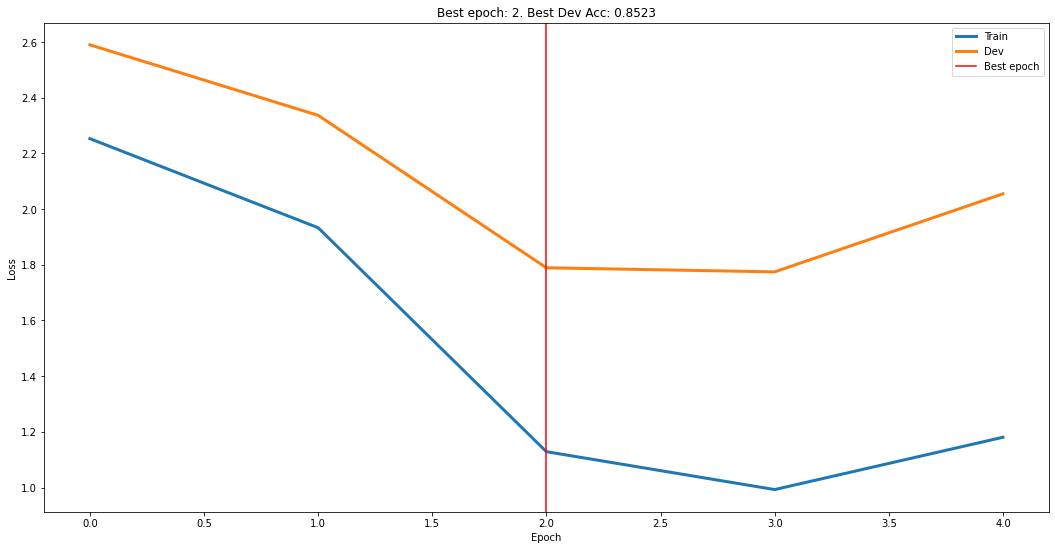


--------------------------------------------------------------------------------

Epoch: 1



Train Avg Acc: 0.9300781488418579
Train Loss: 0.6891401037573814
Train Accs per class: tensor([0.9406, 0.9594, 0.9187, 0.9016])




Dev Avg Acc: 0.830078125
Dev Loss: 2.293345555663109
Dev Accs per class: tensor([0.8359, 0.8859, 0.8031, 0.7953])


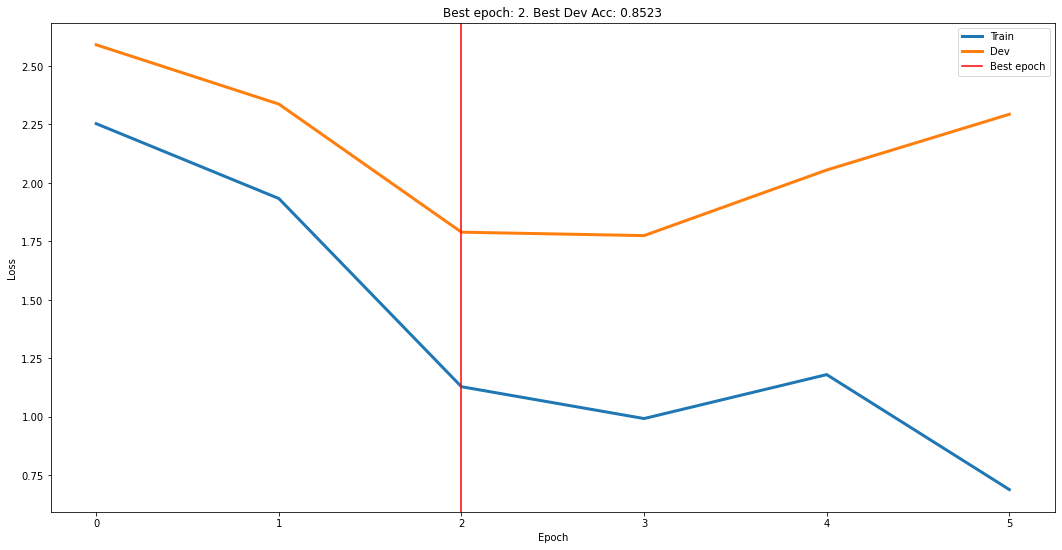


--------------------------------------------------------------------------------

Epoch: 2



Train Avg Acc: 0.9644531011581421
Train Loss: 0.38797084987163544
Train Accs per class: tensor([0.9734, 0.9578, 0.9500, 0.9766])




Dev Avg Acc: 0.8449218273162842
Dev Loss: 2.0323237001895906
Dev Accs per class: tensor([0.8469, 0.8875, 0.7953, 0.8500])


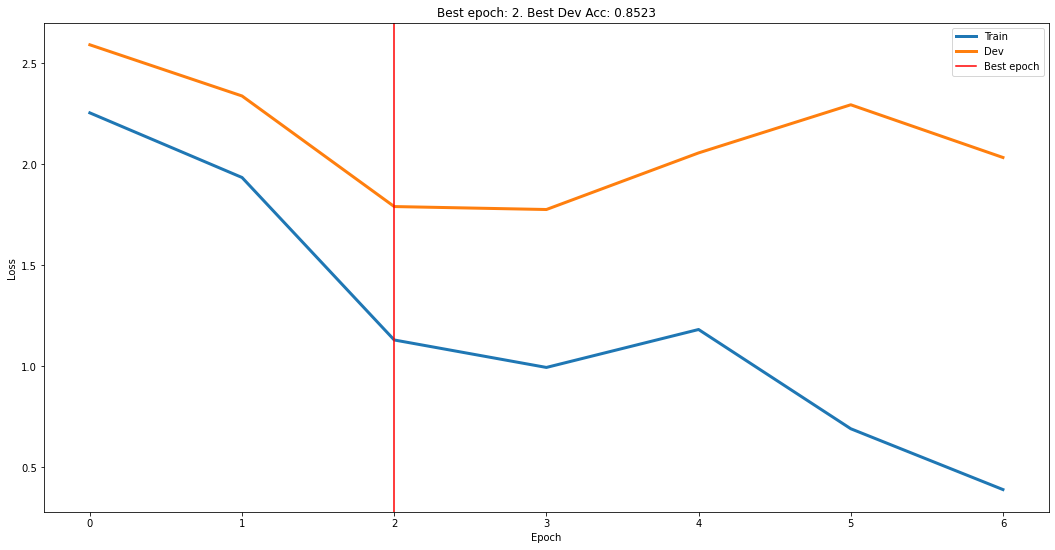


--------------------------------------------------------------------------------

Epoch: 3



Train Avg Acc: 0.9824219346046448
Train Loss: 0.20480070672929288
Train Accs per class: tensor([0.9859, 0.9875, 0.9828, 0.9734])




Dev Avg Acc: 0.8503906726837158
Dev Loss: 1.9600568860769272
Dev Accs per class: tensor([0.8422, 0.8891, 0.8094, 0.8609])


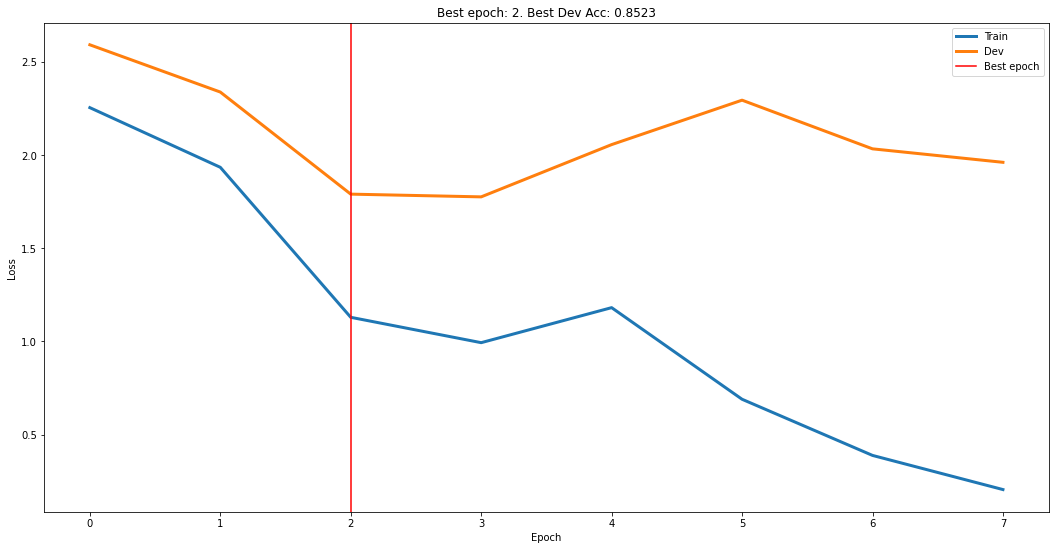


--------------------------------------------------------------------------------

Epoch: 4



Train Avg Acc: 0.9906249642372131
Train Loss: 0.10996460989117622
Train Accs per class: tensor([0.9922, 0.9937, 0.9891, 0.9875])




Dev Avg Acc: 0.857421875
Dev Loss: 1.8940481573343277
Dev Accs per class: tensor([0.8500, 0.8766, 0.8266, 0.8766])


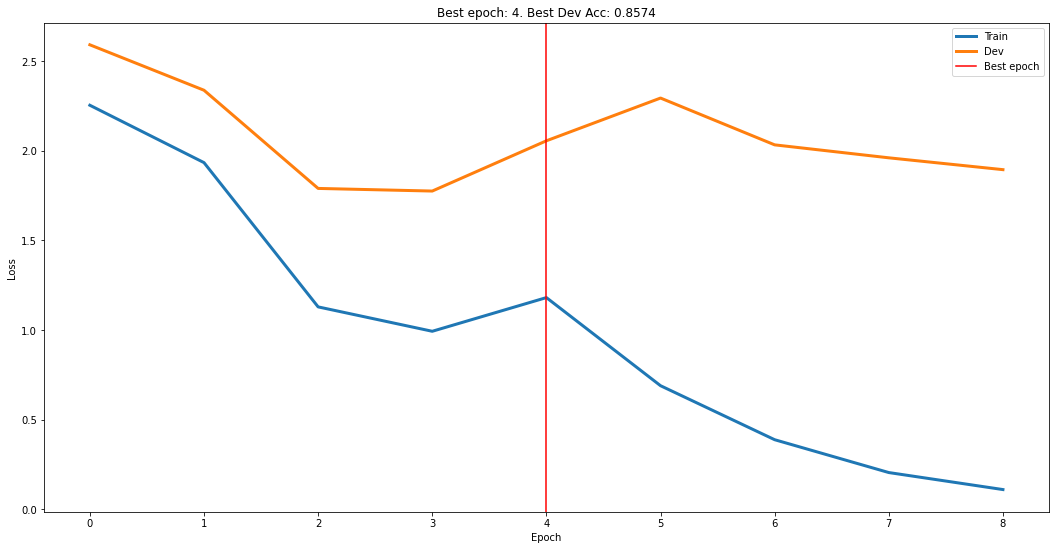


--------------------------------------------------------------------------------

Epoch: 5



Train Avg Acc: 0.9957031011581421
Train Loss: 0.05919672437012195
Train Accs per class: tensor([0.9984, 0.9969, 0.9937, 0.9937])




Dev Avg Acc: 0.8585937023162842
Dev Loss: 1.8818229958415031
Dev Accs per class: tensor([0.8438, 0.8875, 0.8297, 0.8734])


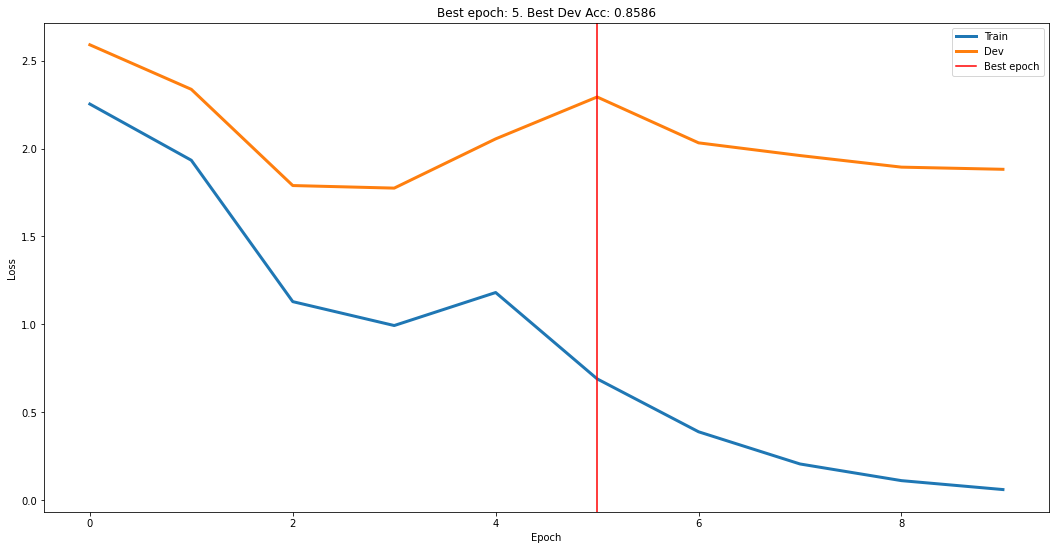


--------------------------------------------------------------------------------

Epoch: 6



Train Avg Acc: 0.9957031607627869
Train Loss: 0.06261377092450857
Train Accs per class: tensor([0.9969, 0.9953, 0.9937, 0.9969])




Dev Avg Acc: 0.8566405773162842
Dev Loss: 1.8890606209635734
Dev Accs per class: tensor([0.8453, 0.8875, 0.8266, 0.8672])


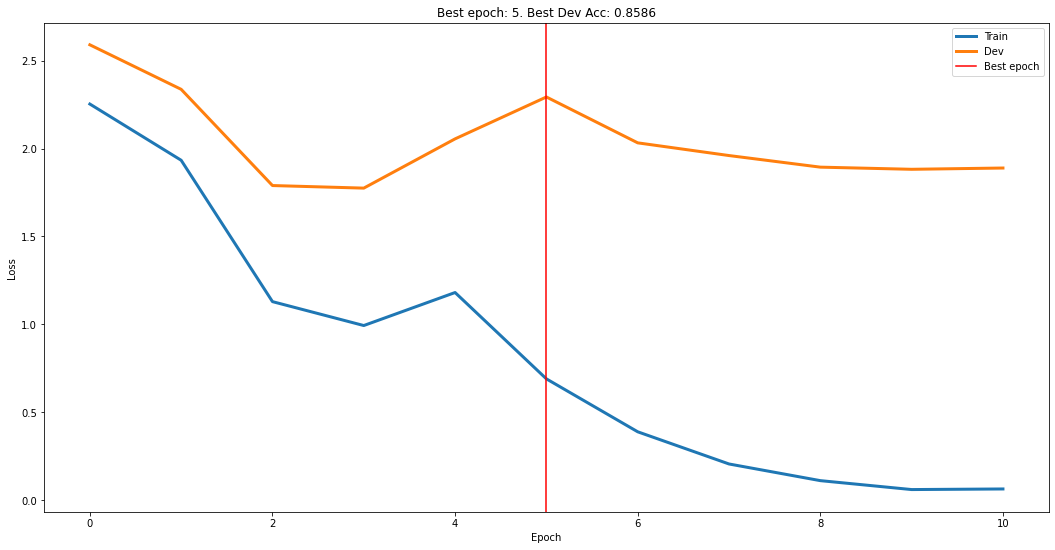


--------------------------------------------------------------------------------

Epoch: 7



Train Avg Acc: 0.99609375
Train Loss: 0.05740363206714392
Train Accs per class: tensor([0.9953, 1.0000, 0.9969, 0.9922])




Dev Avg Acc: 0.8609374761581421
Dev Loss: 1.8785596951842307
Dev Accs per class: tensor([0.8438, 0.8906, 0.8250, 0.8844])


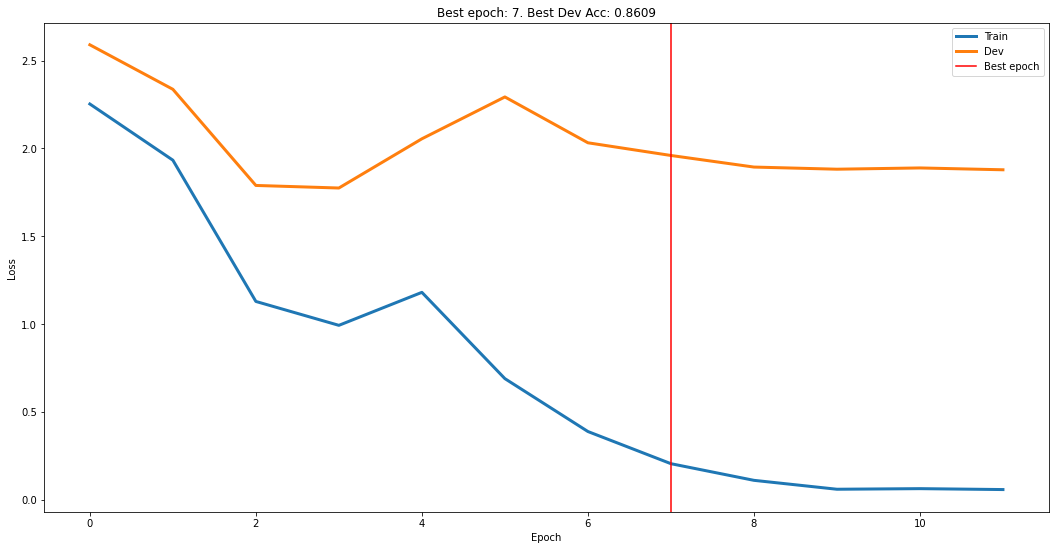


--------------------------------------------------------------------------------

Epoch: 8



Train Avg Acc: 0.994921863079071
Train Loss: 0.07046444267034531
Train Accs per class: tensor([1.0000, 0.9859, 0.9969, 0.9969])




Dev Avg Acc: 0.859375
Dev Loss: 1.8821943283081055
Dev Accs per class: tensor([0.8422, 0.8906, 0.8266, 0.8781])


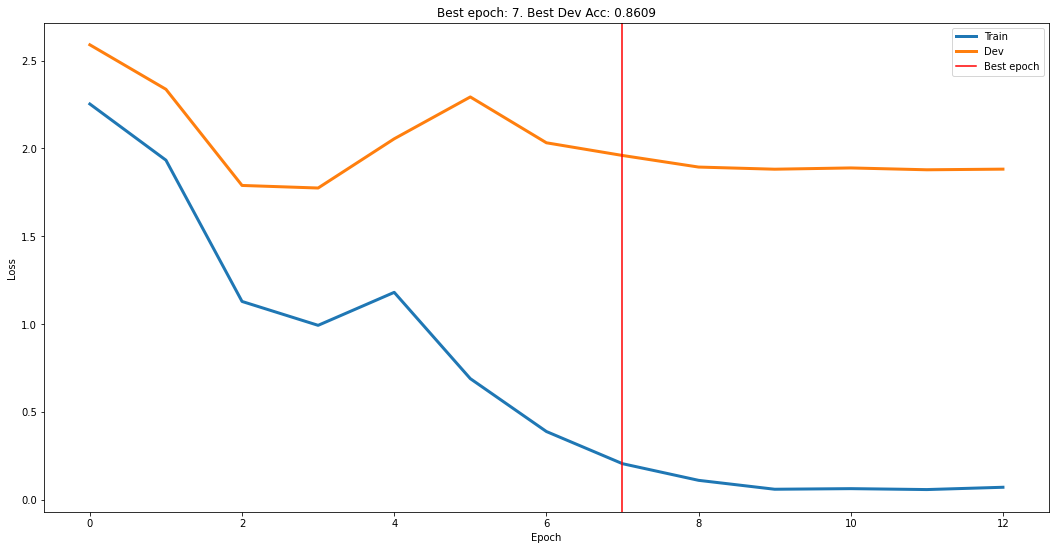


--------------------------------------------------------------------------------

Epoch: 9



Train Avg Acc: 0.9972655773162842
Train Loss: 0.05386906350031495
Train Accs per class: tensor([1.0000, 0.9984, 0.9969, 0.9937])




Dev Avg Acc: 0.8582031726837158
Dev Loss: 1.8645889937877655
Dev Accs per class: tensor([0.8453, 0.8906, 0.8281, 0.8687])


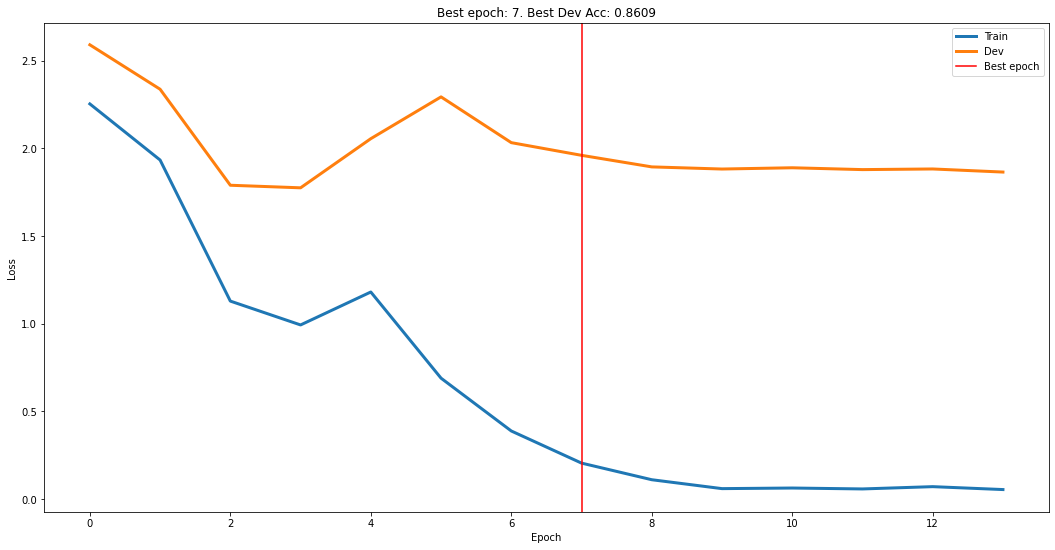


--------------------------------------------------------------------------------




In [93]:
num_epochs = 10

for epoch in trange(num_epochs, desc='epoch'):
    print('Epoch:', epoch)
    # train
    avg_epoch_loss, avg_per_class_acc = train_one_epoch(iterator=train1_dataloader,
                                                        model=model_ft, criterion=criterion,
                                                        optimizer=optimizer_ft)
    avg_acc = avg_per_class_acc.mean().item()
    train_epoch_acc_history.append(avg_acc)
    print('Train Avg Acc:', avg_acc)
    train_epoch_loss_history.append(avg_epoch_loss)
    train_per_class_acc_history.append(avg_per_class_acc)
    print('Train Loss:', avg_epoch_loss)
    print('Train Accs per class:', avg_per_class_acc)
    print()
    
    # evaluate on the dev set
    avg_epoch_loss, avg_per_class_acc = evaluate(iterator=dev1_dataloader,
                                                 model=model_ft, criterion=criterion)
    avg_acc = avg_per_class_acc.mean().item()
    dev_epoch_acc_history.append(avg_acc)
    print('Dev Avg Acc:', avg_acc)
    dev_epoch_loss_history.append(avg_epoch_loss)
    dev_per_class_acc_history.append(avg_per_class_acc)
    print('Dev Loss:', avg_epoch_loss)
    print('Dev Accs per class:', avg_per_class_acc)
    
    if (not best_acc) or avg_acc > best_acc:
        best_epoch = epoch
        best_acc = avg_acc
        
        best_model_wts = copy.deepcopy(model_ft.state_dict())

    # lr scheduler step
    exp_lr_scheduler.step()

    # plot
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_epoch_loss_history)), train_epoch_loss_history, label=f'Train', linewidth=3)
    plt.plot(np.arange(len(dev_epoch_loss_history)), dev_epoch_loss_history, label=f'Dev', linewidth=3)
    plt.axvline(x=best_epoch, label='Best epoch', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Best epoch: {best_epoch}. Best Dev Acc: {best_acc:.4}')
    plt.legend(loc='best')
    plt.show()


    print()
    print('-'*80)
    print()

## Model Name

In [94]:
MODEL_NAME = 'baseline-2021-06-09'

### Save weights

In [95]:
%mkdir ../weights

mkdir: cannot create directory ‘../weights’: File exists


In [96]:
torch.save(model_ft.state_dict(), f'../weights/{MODEL_NAME}.pth')

In [97]:
%ls ../weights

baseline-2021-06-09.pth


### Save history

In [98]:
%mkdir ../history

mkdir: cannot create directory ‘../history’: File exists


In [99]:
history = {
    'train_losses': [float(el) for el in train_epoch_loss_history],
    'dev_losses': [float(el) for el in dev_epoch_loss_history],

    'train_per_class_accuracies': [list(el.numpy().astype(float)) for el in train_per_class_acc_history],
    'dev_per_class_accuracies': [list(el.numpy().astype(float)) for el in dev_per_class_acc_history],

    'train_average_accuracies': [float(el) for el in train_epoch_acc_history],
    'dev_average_accuracies': [float(el) for el in dev_epoch_acc_history],
}

In [100]:
import json

with open(f'../history/{MODEL_NAME}.json', 'w') as fp:
    json.dump(history, fp)

In [ ]:
%ls ../history

In [ ]:
[list(el.numpy()) for el in train_epoch_loss_history]

In [101]:
train_epoch_acc_history

[0.7992187738418579,
 0.835156261920929,
 0.889843761920929,
 0.9046875238418579,
 0.8894531726837158,
 0.9300781488418579,
 0.9644531011581421,
 0.9824219346046448,
 0.9906249642372131,
 0.9957031011581421,
 0.9957031607627869,
 0.99609375,
 0.994921863079071,
 0.9972655773162842]

In [102]:
dev_epoch_acc_history

[0.7964843511581421,
 0.8355469107627869,
 0.8523437976837158,
 0.850390613079071,
 0.834765613079071,
 0.830078125,
 0.8449218273162842,
 0.8503906726837158,
 0.857421875,
 0.8585937023162842,
 0.8566405773162842,
 0.8609374761581421,
 0.859375,
 0.8582031726837158]

In [103]:
history

{'dev_average_accuracies': [0.7964843511581421,
  0.8355469107627869,
  0.8523437976837158,
  0.850390613079071,
  0.834765613079071,
  0.830078125,
  0.8449218273162842,
  0.8503906726837158,
  0.857421875,
  0.8585937023162842,
  0.8566405773162842,
  0.8609374761581421,
  0.859375,
  0.8582031726837158],
 'dev_losses': [2.5903433471918107,
  2.3369307965040207,
  1.7893472969532014,
  1.774703386425972,
  2.0550144612789154,
  2.293345555663109,
  2.0323237001895906,
  1.9600568860769272,
  1.8940481573343277,
  1.8818229958415031,
  1.8890606209635734,
  1.8785596951842307,
  1.8821943283081055,
  1.8645889937877655],
 'dev_per_class_accuracies': [[0.793749988079071,
   0.770312488079071,
   0.8453124761581421,
   0.776562511920929],
  [0.807812511920929, 0.8828125, 0.8109375238418579, 0.840624988079071],
  [0.846875011920929,
   0.8890625238418579,
   0.832812488079071,
   0.840624988079071],
  [0.8453124761581421, 0.8812500238418579, 0.839062511920929, 0.8359375],
  [0.8609374761

history
history


In [4]:
%store -r history

no stored variable history
